In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

import pycutest


from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

In [2]:
import sys
sys.path.append("..")
from Functions import PyCutestWrapper
from USimplex import USD

In [545]:
def simplex_gradient(F, x_0, S, jrandom_key_f):
    num_func_calls = 0
    jrandom_key, subkey = jrandom.split(jrandom_key_f)
    FS = []
    for s_i in S.T:
        jrandom_key, subkey = jrandom.split(jrandom_key)
        FS.append(F.f(s_i + x_0, subkey))
        num_func_calls += 1
    FS = jnp.array(FS)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    F_x_0 = F.f(x_0, subkey)
    num_func_calls += 1
    SS_inv = jnp.linalg.inv(S.dot(S.T))
    return SS_inv.dot(S.dot(FS - F_x_0)), num_func_calls




def get_a(D_min, sum_sqrt, dim, sig):
    disc = sig**4 * (sum_sqrt**2) * (8 * (dim + 1) * D_min + sum_sqrt**2)
    return 1/jnp.sqrt(dim * D_min) * jnp.sqrt(jnp.sqrt(disc) + 2 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2)

def get_lambda_max(D_min, sum_sqrt, dim, sig):
    disc = sig**4 * (sum_sqrt**2) * (8 * (dim + 1) * D_min + sum_sqrt**2)
    numerator = jnp.sqrt(disc) + 4 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2
    denom = D_min**(1.5) * 2 * jnp.sqrt(1/dim) * jnp.sqrt(jnp.sqrt(disc) + 2 * (dim + 1) * D_min * sig**2 + sig**2 * sum_sqrt**2)
    return numerator/denom

def get_full_sing_vals(D, dim, sig):
    D_diag = jnp.abs(jnp.diag(D))
    max_row = jnp.argmin(D_diag)
    sum_sqrt = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_diag[max_row])
    lmbda_max = get_lambda_max(jnp.min(D_diag), sum_sqrt, dim, sig)
    a = get_a(jnp.min(D_diag), sum_sqrt, dim, sig)
    lmbda = sig*np.array(jnp.sqrt(lmbda_max / (a * D_diag)))
    lmbda = lmbda.at[max_row].set(lmbda_max)
    lmbda = jnp.array(lmbda)
    sing_val = jnp.sqrt(lmbda)
    return sing_val

def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper


def generate_regular_simplex(dim):
    res = []
    I = np.eye(dim)
    for i in range(dim):
        res.append(jnp.sqrt(1 + 1/dim) * I[i] - 1/pow(dim, 3/2) *(np.sqrt(dim + 1) + 1) * np.ones(dim))
        
    res.append(1/np.sqrt(dim) * np.ones(dim))
    
    return jnp.array(res).T

def convert_to_U(W, to_insert):
    dim = W.shape[0] + 1
    V = generate_regular_simplex(dim - 1)
    tmp_U = (jnp.sqrt((dim - 1)/dim) * W @ V)
    U = jnp.insert(tmp_U, to_insert, jnp.ones(shape=(1, dim))/jnp.sqrt(dim), axis=0)
    return U

def construct_c(sing_vals, D):
    return sing_vals**2 * jnp.diag(D)

def orthog_linesearch(l, c1, c2):

    def helper(X, search_direction, A):
        f0 = l(X)
        g_tau_0 = -1/2 * jnp.linalg.norm(A, "fro")**2
        
        def armijo_rule(alpha):
            return (l(search_direction(alpha)) > f0 + c1*alpha*g_tau_0) # and alpha > 0.001
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        max_calls = 1000
        while armijo_rule(alpha):# and max_calls > 0:
            alpha = armijo_update(alpha)
            max_calls -= 1

        return alpha

    return helper


def optimize_W(c, num_iter, x_init=None):
    """Constraint is U.c = \bar{c} 1 and U.U^T = I"""
    
    dim = len(c)
    
    V = generate_regular_simplex(dim)
    
    # init X
    if x_init is None:
        X = jnp.eye(dim)
    else:
        X = x_init
    I = jnp.eye(dim)
    
    
    def l(U):
        U_matrix = U.reshape(dim, dim)
        return jnp.linalg.norm(jnp.diag(V.T @ U_matrix.T @ jnp.diag(c) @ U_matrix @ V) - jnp.ones(dim + 1) * jnp.mean(c)) 
    
    
    g_l = grad(l)
    linesearch = orthog_linesearch(l, c1=0.1, c2=0.9)


    eps = 1e-4
    l_eps = 1e-2
    
    l_hist = []
    for _ in tqdm(range(num_iter)):
        num_iter -= 1
        
        G = g_l(X.flatten()).reshape(dim, dim)
        l_hist.append(l(X))
        
        if l_hist[-1] < l_eps:
            break

        if jnp.linalg.norm(G) < eps:
            break
        
        A = G @ X.T - X @ G.T
                
        Y = lambda tau: jnp.linalg.inv(I + tau/2 * A) @ (I - tau/2 * A) @ X
        
        alpha = linesearch(X, Y, A)

        
        X = Y(alpha)
    # plt.plot(l_hist)
    # plt.show()
    print(l_hist[-1])
    return X, l_hist


def create_S(H, sig, num_iter=10, x_init=None):
    dim = H.shape[0] 

    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U_D = jnp.linalg.eig(H)
    U_D = jnp.real(U_D)
    D = jnp.abs(jnp.real(jnp.diag(D)))
    # print(repr(jnp.diag(D)))
    # D = D + 0.01 * jnp.eye(dim)
    # print(D)

    sing_vals = get_full_sing_vals(D, dim, sig)
    c = construct_c(sing_vals, D)
    min_D = jnp.diag(D).argmin()
    W, l_hist = optimize_W(np.delete(c, min_D), num_iter, x_init=x_init) 
    U = convert_to_U(W, min_D)
    S = jnp.diag(sing_vals) @ U

    return U_D @ S, W


In [546]:
cutest_f = pycutest.import_problem("BIGGS5")
eps = 0.1
sig = eps/jnp.sqrt(3)
noise_type = "uniform"
F = PyCutestWrapper(cutest_f, eps, noise_type)
x_0 = jnp.array(cutest_f.x0)
jrandom_key = jrandom.PRNGKey(0)



In [547]:
H = F.f2(x_0)
f1 = F.f1(x_0)

dim = H.shape[0] 

H = (H + H.T) / 2. # to combat numerical inaccuracies. 
D, U_D = jnp.linalg.eig(H)
U_D = jnp.real(U_D)
D = jnp.real(jnp.diag(D))


mse_loss = loss_getter(dim, dim, H, sig)

100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.07it/s]


0.2619609503742462


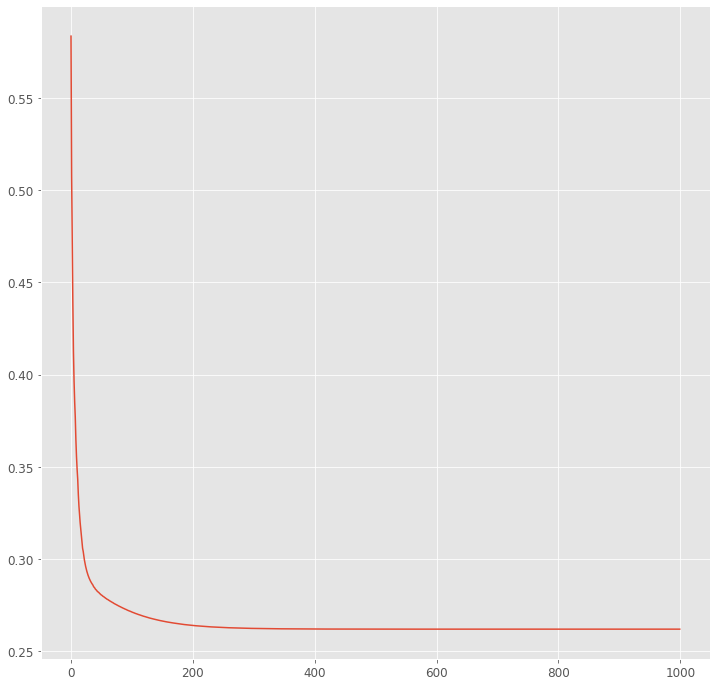

In [385]:
sing_vals = get_full_sing_vals(D, dim, sig)
c = construct_c(sing_vals, D)
min_D = jnp.diag(D).argmin()


W, l_hist = optimize_W(np.delete(c, min_D), 1000, x_init=jnp.eye(dim - 1)) 
plt.plot(l_hist)
plt.show()


In [386]:
U = convert_to_U(W, min_D)
S = jnp.diag(sing_vals) @ U
S = U_D @ S

mse_loss(S)

DeviceArray(98.1855226, dtype=float64)

In [387]:
V = generate_regular_simplex(5)
U_matrix = U

jnp.diag(V.T @ U_matrix.T @ jnp.diag(c) @ U_matrix @ V)


DeviceArray([1.16301614, 0.88484976, 0.97171415, 0.97171383, 1.16300658,
             3.70486369], dtype=float64)

In [447]:
print("true grad", F.f1(x_0))

true grad [ 1.26263701 -0.58071465 -0.61127356 -0.26607037  0.30967437]


In [642]:
jrandom_key, subkey = jrandom.split(jrandom_key)
print("simplex grad", simplex_gradient(F, x_0, jnp.diag(sing_vals), jrandom_key))
print("simplex grad", simplex_gradient(F, x_0, S, jrandom_key))
print("simplex grad opt_S", simplex_gradient(F, x_0, opt_S, jrandom_key))





simplex grad (DeviceArray([ 1.52985436, -0.40769232,  3.62673255,  2.05152286,
              0.2820486 ], dtype=float64), 6)
simplex grad (DeviceArray([-28.27337028,   1.22197152,  24.71828913,  -9.97615798,
              -7.70390385], dtype=float64), 6)
simplex grad opt_S (DeviceArray([ 0.21725892, -0.59387414, -0.44979869, -0.33098876,
             -0.23477427], dtype=float64), 6)


In [452]:
jnp.linalg.svd(S)

(DeviceArray([[ 0.01205802, -0.64039668,  0.2669273 , -0.67088887,
               -0.2615428 ],
              [ 0.55937332, -0.54540392,  0.23077164,  0.53908061,
                0.21394533],
              [ 0.39291472,  0.15666659, -0.13558945, -0.48907383,
                0.75066363],
              [ 0.70461442,  0.4330183 ,  0.13479597, -0.14156613,
               -0.52706997],
              [ 0.18998062, -0.28350907, -0.91593658, -0.00812647,
               -0.21100738]], dtype=float64),
 DeviceArray([13.11861449,  1.14270195,  1.0298615 ,  0.77327792,
               0.40538438], dtype=float64),
 DeviceArray([[ 4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
                4.47213595e-01,  4.47213595e-01],
              [ 7.07105396e-01,  6.44379372e-07,  1.62577464e-04,
               -1.60489324e-04, -7.07108129e-01],
              [-1.60532030e-04, -5.69582878e-06,  7.07108609e-01,
               -7.07104916e-01,  1.62534755e-04],
              [ 8.48454847e-02, -8.63204468e-

In [453]:
sing_vals

DeviceArray([ 0.40538438,  0.77327792,  1.0298615 ,  1.14270195,
             13.11861449], dtype=float64)

In [964]:


def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper

# def loss_getter(dim, N, H, sig):
#     def helper(X):

#         U = X.reshape(N, dim).T
#         S = U
        
#         S_inv = jnp.linalg.inv(S)
        
#         first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
#         second_term = jnp.linalg.norm(S_inv, ord="fro")**2
#         third_term = S_inv.T @ jnp.ones(dim)
#         third_term = jnp.linalg.norm(third_term)**2
        
#         return jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

#     return helper

def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + jnp.linalg.norm(S)**4

    return helper

def optimize_uncentered_S(H, sig, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eig(H)
    U = jnp.real(U)

    # print("D", repr(jnp.real(D)))
#     D = jnp.abs(jnp.real(jnp.diag(D)))
    D = jnp.diag(D)

    if x_curr is None:

        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
        

    
    l = loss_getter(dim, N, D, sig)
    g_l = grad(l)
    h_l = jacfwd(g_l)
    linesearch = helper_linesearch(l, g_l, c1=0.1, c2=0.9)

    eps = 1e-20

    res = []
    res_x = []

    for t in tqdm(range(max_steps)):

        
        res.append(l(x_curr))
#         res_x.append(U.dot(x_curr.reshape(N, dim).T)) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
#         print(curr_grad)
    
        # print(curr_grad)
        curr_hess = h_l(x_curr) #+ 0.1*jnp.eye(dim**2)
        search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(dim**2))*0.1
#         search_direction = -curr_grad + np.random.normal(size=(dim * dim))*0.1

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)


        S = x_curr.reshape(N, dim).T

        SS = S.dot(S.T)

        x_curr += alpha*search_direction 
    
    return U.dot(x_curr.reshape(N, dim).T), res

In [965]:
jrandom_key = jrandom.PRNGKey(12)
jrandom_key, subkey = jrandom.split(jrandom_key)

D = jnp.diag(jnp.array([-15, -1, -3, 4, 20]))
dim = 5
sig = 0.1

l = loss_getter(dim, dim, D, sig)
g_l = grad(l)

opt_S, l_hist = optimize_uncentered_S(D, sig=sig, max_steps=10, jrandom_key=jrandom_key, x_curr=opt_S.T.flatten())



100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.25it/s]


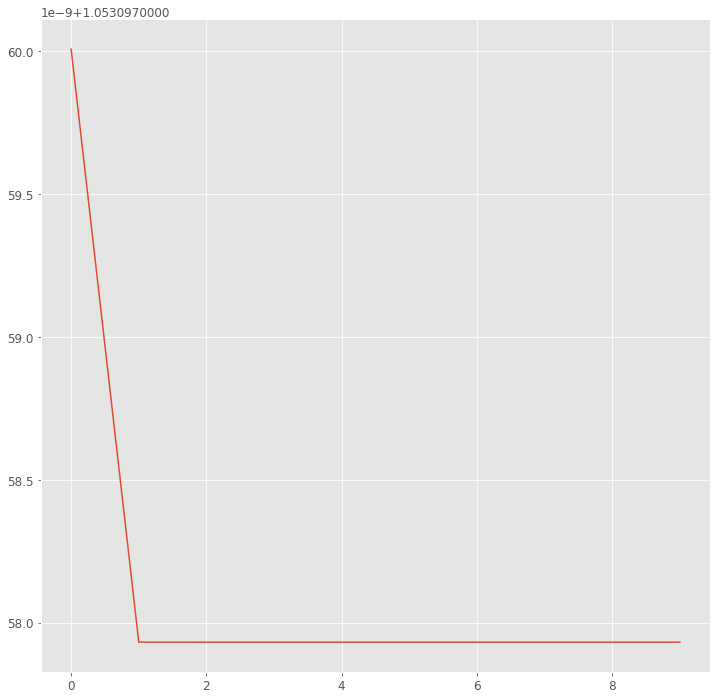

In [966]:
plt.plot(l_hist)

In [967]:
g_l(opt_S.T.flatten())

DeviceArray([-9.01673181e-12,  2.18985940e-12, -8.19552759e-13,
              1.59705582e-12,  7.06629200e-12,  1.96445638e-12,
              2.04847250e-12,  1.11537168e-12, -2.17026050e-13,
             -3.75888209e-12, -5.80907544e-12,  1.08352216e-12,
             -1.92096339e-12, -3.92866295e-13, -5.62594415e-12,
              3.55912522e-12,  6.50979270e-13, -5.17619281e-12,
             -7.64638353e-13,  9.82375292e-12,  3.22636362e-12,
              4.37205827e-13,  3.86357613e-14,  1.36135547e-12,
             -3.66917607e-12], dtype=float64)

In [940]:
jnp.linalg.eig(jacfwd(g_l)(opt_S.T.flatten()))

[DeviceArray([ 1.30720795e+03+0.j,  8.27363014e+02+0.j,
               5.90981479e+02+0.j,  4.24048118e+01+0.j,
               3.95600313e+01+0.j, -2.73588573e+01+0.j,
               4.84037490e+01+0.j, -2.39439687e+01+0.j,
               2.40536480e+01+0.j, -2.29936626e-03+0.j,
               2.04360468e+01+0.j,  1.39694060e+01+0.j,
               1.31466834e+01+0.j,  1.13595794e+01+0.j,
               2.46115621e+00+0.j,  8.75240173e+00+0.j,
               9.93114886e+00+0.j,  1.02979358e+01+0.j,
               5.22491574e+00+0.j,  4.46008174e+00+0.j,
               4.72211452e+00+0.j,  6.40211690e-01+0.j,
               1.01845237e+01+0.j,  3.69281923e+00+0.j,
               4.63058215e+00+0.j], dtype=complex128),
 DeviceArray([[-1.18862301e-01+0.j,  4.86673419e-01+0.j,
                4.71776718e-01+0.j,  3.00813832e-02+0.j,
                8.64987946e-03+0.j, -1.48792843e-03+0.j,
                3.92753567e-17+0.j,  4.10775740e-17+0.j,
                2.54397978e-16+0.j,  2.549188

In [946]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-6.38803782e-01,  7.68973390e-01, -2.55384602e-12,
                2.46911706e-02, -3.08387225e-16],
              [ 7.66249274e-01,  6.38772681e-01,  1.48553669e-11,
               -6.95090774e-02, -3.03391737e-16],
              [-3.93748071e-17, -2.77827866e-16, -5.01999665e-17,
                2.36304382e-17, -1.00000000e+00],
              [ 1.27927668e-11,  7.44376782e-12, -1.00000000e+00,
               -4.28679314e-12,  7.98597453e-17],
              [-6.92226762e-02, -2.54830700e-02,  3.19980153e-12,
               -9.97275706e-01,  6.39222855e-17]], dtype=float64),
 DeviceArray([0.48253651, 0.31378798, 0.30533245, 0.29871853, 0.22193108],            dtype=float64),
 DeviceArray([[ 4.53095775e-01,  4.34702952e-01,  4.59864246e-01,
                4.34702952e-01,  4.53095775e-01],
              [-3.04000786e-01,  5.54087207e-01, -4.48488325e-01,
                5.54087207e-01, -3.04000786e-01],
              [ 7.07106781e-01,  1.32663325e-11,  1.78260462e-11,
   

In [968]:
jnp.diag(opt_S.T @ D @ opt_S)

DeviceArray([-2.54074539e-13, -2.22905028e-13, -1.92956762e-13,
             -3.17301740e-13, -5.86197757e-14], dtype=float64)

In [878]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-9.99307563e-01,  2.18516600e-15,  4.09985761e-14,
                3.91690211e-03,  3.70007049e-02],
              [ 2.23632144e-15,  1.00000000e+00,  4.37167968e-14,
               -4.21705802e-15, -2.95587398e-16],
              [ 4.03980841e-14, -4.40746888e-14,  1.00000000e+00,
               -6.95375486e-14, -9.59040604e-15],
              [ 3.89913526e-03,  4.10929294e-15,  6.93388381e-14,
                9.99992246e-01, -5.52324393e-04],
              [-3.70025814e-02, -2.03529256e-16, -8.24857444e-15,
               -4.07671191e-04, -9.99315087e-01]], dtype=float64),
 DeviceArray([0.49203156, 0.30083822, 0.30004298, 0.29911264, 0.28504604],            dtype=float64),
 DeviceArray([[-4.44498314e-01, -4.44782476e-01, -4.44782476e-01,
               -4.50975802e-01, -4.50975802e-01],
              [-3.07583775e-15, -4.09925726e-14,  4.66332166e-14,
               -7.07106781e-01,  7.07106781e-01],
              [-3.64486773e-12,  7.07106781e-01, -7.07106781e-01,
   

In [203]:
V, sing_vals, U = jnp.linalg.svd(opt_S)

In [205]:
V @ jnp.diag(sing_vals)

DeviceArray([[ 5.57458916e-01, -3.22416608e-02,  6.31891790e-17,
               5.17842654e-18],
             [ 4.41027518e-02,  4.07534689e-01, -1.57972947e-17,
               4.18779847e-17],
             [ 1.24167513e-16, -1.13467036e-16, -1.89719175e-01,
              -8.99862621e-16],
             [-2.69807095e-17, -9.63238765e-17, -9.73062168e-16,
               1.75447366e-01]], dtype=float64)

In [181]:
sing_vals

DeviceArray([0.4728708 , 0.31622777, 0.31622777, 0.31622777], dtype=float64)

In [224]:
D

DeviceArray([[-1.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  2.66666667,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  6.33333333,  0.        ],
             [ 0.        ,  0.        ,  0.        , 10.        ]],            dtype=float64)

In [229]:
old_opt_S = V @ jnp.diag(sing_vals) @ U

In [331]:
(sig**2 * (5 ) / 2)**(1/6.)

0.5407418735600995

In [928]:
sing_vals = jnp.array([0.47436416, 0.30309184, 0.30309177, 0.30309176, 0.30309169])

-(6)/sing_vals[0]**4 * 0.1**2 + 2 * jnp.sum(sing_vals**2)

DeviceArray(-5.72440205e-07, dtype=float64)